In [80]:
# base
import pandas as pd
from pandas.api.types import CategoricalDtype, is_categorical_dtype
import numpy as np
import scanpy.api as sc
import scanpy.external
import anndata as ad
import scipy.stats as ss

#plotting
from plotnine import *
import plotnine
import matplotlib as mp
from adjustText import adjust_text


# ingest data and update labels
adata = sc.read_h5ad('/mnt/ibm_lg/bingwu/AnnData/TA_COMET_1024Day0to16_MonoMac.h5ad')
adata.obs['day'] = [int(x[3:]) for x in adata.obs['TACollectionDay']] 

def prepare_dataframe(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7):
    """
    ### FROM scanpy ###
    
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
#     sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

def adata_DE_pairwise(input_adata, 
                      groupby, 
                      target_1, 
                      target_2, 
                      method = 'wilcoxon',
                      corr_method = 'benjamini-hochberg'
                     ):
    """
    Wrapper for scanpy DE tests. Two-sided.
    
    Input: adata, groupby variable, comparison labels, test, mutliple hypothesis procedure
    Output: dataframe of gene, log2fc, pval, adj_pval
    """
    
    n_genes=len(input_adata.var_names)
    sc.tl.rank_genes_groups(input_adata, 
                            groupby=groupby, 
                            groups=[target_1],
                            reference=target_2,
                            method=method,
                            n_genes = n_genes,
                            corr_method = corr_method
                           )
    genes = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
    log2change = [x[0] for x in input_adata.uns['rank_genes_groups']['logfoldchanges']]
    pvals = [x[0] for x in input_adata.uns['rank_genes_groups']['pvals']]
    pvals_adj = [x[0] for x in input_adata.uns['rank_genes_groups']['pvals_adj']]
    
    results_df = pd.DataFrame({
        'gene':genes,
        'log2change':log2change,
        'pvals':pvals,
        'pvals_adj':pvals_adj
    })
    
    return results_df

def hmean(a):
    """
    harmonic mean
    ref = https://stackoverflow.com/questions/10712842/harmonic-mean-in-python
    
    """
    return len(a) / np.sum(1.0/a) 

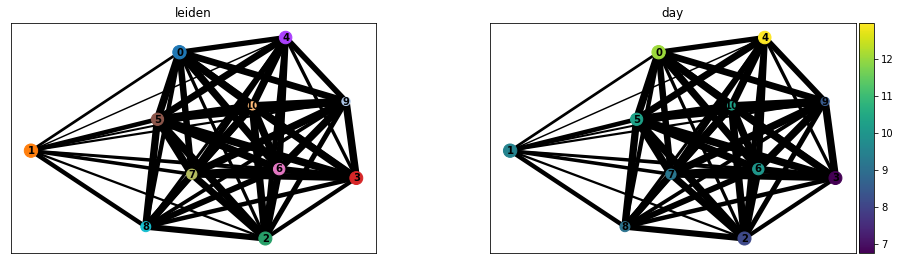

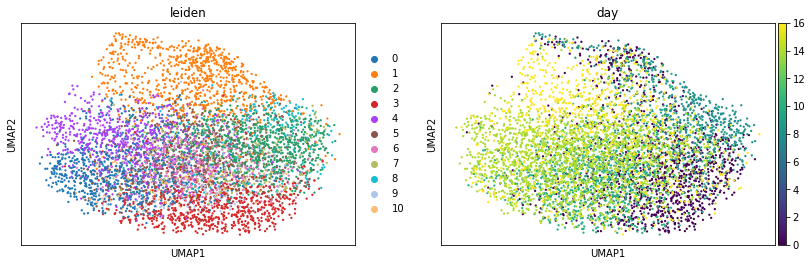

In [81]:
n_pcs = 200
cluster_res = 1

sc.tl.pca(adata,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center = False)
sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=15, random_state=1)
sc.tl.leiden(adata, resolution = cluster_res, random_state=1)
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, colors=['leiden','day'])
sc.tl.umap(adata, init_pos = 'paga')
sc.pl.umap(adata, color = ['leiden','day'])


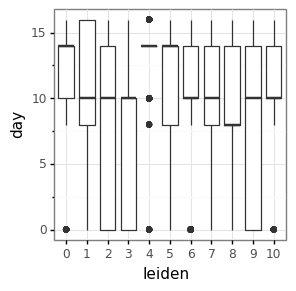

<ggplot: (8726381598341)>


In [82]:
df = adata.obs.loc[:,['leiden','day']]

plotnine.options.figure_size=(3,3)
plot = (ggplot(df)
        + theme_bw()
        + geom_boxplot(aes('leiden','day'))
       )
print(plot)

# DE analysis

... storing 'de_groups' as categorical


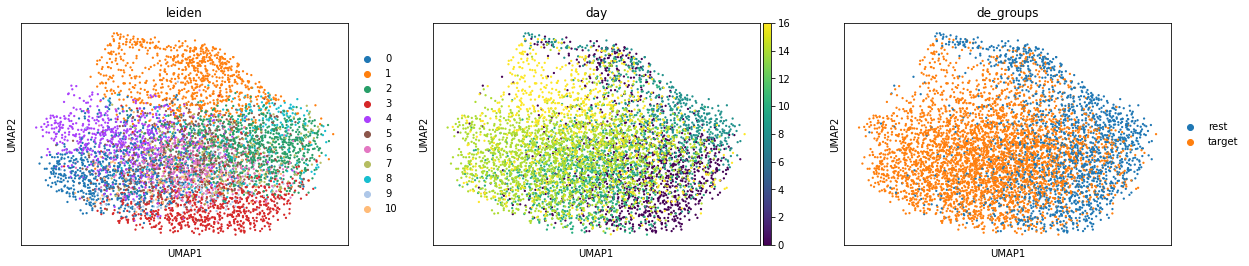

/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 3269 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


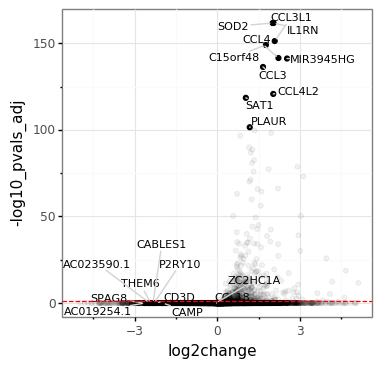

In [83]:
# adata.obs['de_groups'] = ['target' if x in ['3','4','5'] else 'rest' for x in adata.obs['leiden']]
adata.obs['de_groups'] = ['target' if x >= 9 else 'rest' for x in adata.obs['day']]
sc.pl.umap(adata, color = ['leiden','day','de_groups'])

results_df = adata_DE_pairwise(adata, 
                      'de_groups', 
                      'target', 
                      'rest', 
                      method = 'wilcoxon',
                      corr_method = 'benjamini-hochberg'
                     )
results_df = results_df.dropna()
# log transform
results_df['-log10_pvals_adj'] = [-np.log10(x) for x in results_df['pvals_adj']]
# replace inf with machine precision
results_df = results_df.replace(np.inf, np.nan)
results_df = results_df.replace(np.nan, np.nanmax(results_df['-log10_pvals_adj'].values))
# append top DE genes
neg_geneset = (results_df[results_df['log2change'] < 0]
               .sort_values('-log10_pvals_adj', ascending=False)
               .gene.tolist()
              )
pos_geneset = (results_df[results_df['log2change'] > 0]
               .sort_values('-log10_pvals_adj', ascending=False)
               .gene.tolist()
              )
# add multitest cutoff
alpha = 0.05
threshold = -np.log10(alpha)

# plot variables
gene_n = 10
results_df['GOI'] = [x in pos_geneset[:gene_n]+neg_geneset[:gene_n] for x in results_df.gene]

# determine xlim
xlim_df = results_df.sort_values(['-log10_pvals_adj'], ascending = False)
xlim_df['rank'] = xlim_df['-log10_pvals_adj'].rank(pct = True)
xlim_val = xlim_df[xlim_df['rank'] > 0.95]['log2change'].abs().max()

plotnine.options.figure_size = (4,4)
plot = (ggplot(results_df)
        + theme_bw()
        + theme(legend_position = 'none')
        + geom_point(aes('log2change','-log10_pvals_adj'), alpha = 0.05)
        + geom_text(results_df[results_df['GOI']==True], 
                    aes('log2change','-log10_pvals_adj',label='gene'),
                    size = 8)
        + geom_point(results_df[results_df['GOI']==True], aes('log2change','-log10_pvals_adj'))
        + geom_hline(aes(yintercept = threshold), linetype = '--', color = 'red')
        + scale_x_continuous(limits=(-xlim_val,
                                     xlim_val))
       )
f = plot.draw()
for a in f.axes:
    texts = [t for t in  a.texts]
    adjust_text(texts,ax=a, arrowprops=dict(arrowstyle='-', color='#D3D3D3'),
                force_text=(0.1, 1),
#                 force_points=(1, 1),
                expand_text=(1.3, 1.3),
#                 expand_points=(2, 2)
               )

## spearman coorelation

In [84]:
_,df = prepare_dataframe(adata,
                         adata.var_names,
                         'TACollectionDay'
                        )
hivar_genes = pd.DataFrame(adata.var.highly_variable).query('highly_variable == True').index.tolist()
df = df.loc[:, hivar_genes]
df['day']=[int(x[3:]) for x in df.index]

pvals = []
rhos = []
day_arr = df['day'].values
for gene in hivar_genes:
    rho,pval = ss.spearmanr(day_arr, df[gene].values)
    rhos.append(rho)
    pvals.append(pval)
    
results_df = pd.DataFrame({'gene':hivar_genes,
                           'rho':rhos,
                           'pval':pvals
                          })
    

In [85]:
results_df.sort_values('rho')

,gene,rho,pval
868,AL133415.1,-0.298423,1.351154e-119
467,AL662899.2,-0.223020,2.815421e-66
19,CD52,-0.200353,1.394662e-53
72,AC245014.3,-0.158995,3.849177e-34
1048,RNASE1,-0.147832,1.076050e-29
...,...,...,...
352,CXCL10,0.213851,5.791987e-61
51,GBP4,0.214246,3.461273e-61
685,IDO1,0.236260,2.206993e-74
1441,IL4I1,0.246675,3.991427e-81


## testing correlation over time

In [239]:
input_adata = adata
_,df = prepare_dataframe(input_adata,
                         input_adata.var_names,
                         'TACollectionDay'
                        )
# df = df.rank(pct=True, axis=1)
hivar_genes = (pd.DataFrame(input_adata
                           .var
                           .highly_variable)
               .query('highly_variable == True')
               .index
               .tolist()
              )
df = df.loc[:, hivar_genes]
df['day']=[int(x[3:]) for x in df.index]

# create correlation matrix by day
tstack = np.zeros((len(hivar_genes),len(hivar_genes),len(set(df['day']))))
for idx,day in enumerate(set(df['day'])):
    corr = (df
               .query(f'day == {day}')
               .drop('day', axis=1)
               .corr()**2
              )
    corr = corr.replace(0,0.000001)
    tstack[:,:,idx] =np.array(corr)

# stack and compute harmonic mean
tstack_hmean = np.apply_along_axis(hmean, 2, tstack)
tstack_hmean_triu = np.triu(tstack_hmean, k=1)
tstack_hmean_triu[tstack_hmean_triu == 0] = np.nan
tstack_df = pd.DataFrame(tstack_hmean_triu)
tstack_df.columns = corr.columns
tstack_df['gene'] = corr.columns
tstack_melt = (pd.melt(tstack_df, id_vars='gene')
               .dropna()
               .sort_values('value', ascending = False)
              )

In [240]:
# output top correlated gene pairs
tstack_melt_slice = tstack_melt.head(100)

# create contig networks
cluster_lists = []
pair_list = [(x,y) for x,y in zip(tstack_melt_slice['gene'], tstack_melt_slice['variable'])]
possible_genes = [ele for sublist in pair_list for ele in sublist]
possible_genes = list(set(possible_genes))

# testing
# pair_list = [['a','b'], ['a','c'], ['d','e'],['c','a']]
# possible_genes = [ele for sublist in pair_list for ele in sublist]

for key in possible_genes:
    contig_cluster = [key]
    current_step = contig_cluster
    # step1: look for partners
    if len(current_step) > 0:
        next_step = []
        for x in current_step:
            match_list = [sublist for sublist in pair_list if x in sublist]
            match_list = [ele for sublist in match_list for ele in sublist]
            for y in match_list:
                if y not in contig_cluster:
                    contig_cluster.append(y)
                    next_step.append(y)
                
        current_step = next_step

    cluster_lists.append(frozenset(contig_cluster))

cluster_lists = [list(x) for x in set(cluster_lists)]

0 ['AKR1B1', 'SERPINE1', 'APOE', 'TMEM176A', 'PMP22', 'SELENOP', 'ACP2', 'PLA2G7', 'TREM2', 'RNASE1', 'FN1', 'SDSL', 'MSR1', 'FCGR3A', 'SLAMF8', 'HSD17B14', 'NUPR1', 'FBP1', 'LPL', 'PLTP', 'GPNMB', 'MATK', 'APOC2', 'SDS', 'NCEH1', 'A2M', 'CCL18', 'TMEM176B', 'CD276', 'HLA-DMB', 'TSPAN4', 'VSIG4', 'MRC1']


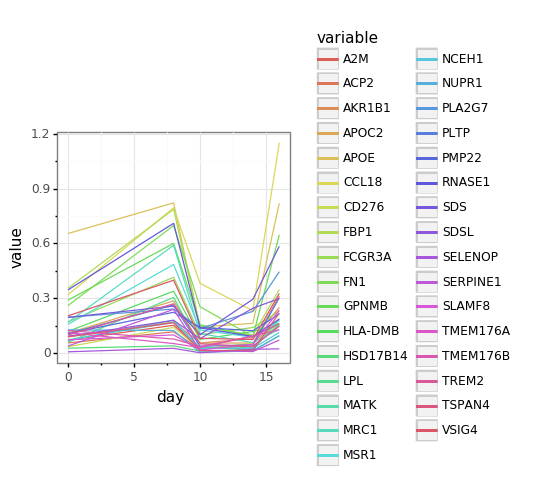

<ggplot: (8726355573937)>
1 ['SERPINB2', 'CXCL5']


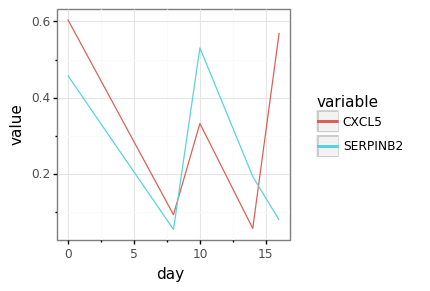

<ggplot: (8726355523013)>
2 ['ZP3', 'POMZP3']


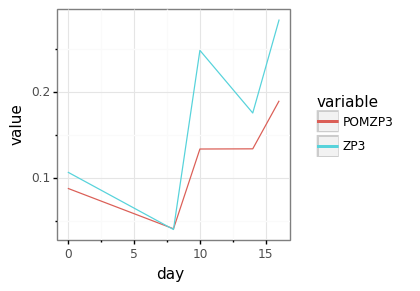

<ggplot: (8726355547433)>
3 ['EBI3', 'ADA', 'TNFRSF4']


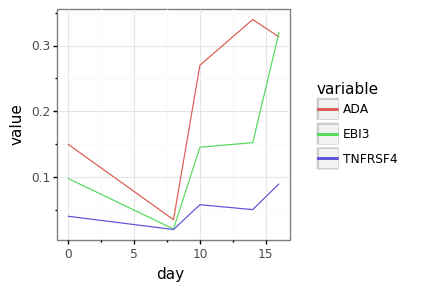

<ggplot: (8726355568257)>
4 ['AC007952.4', 'AC245014.3', 'WDR74']


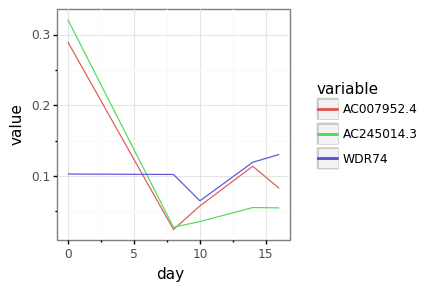

<ggplot: (8726355876737)>
5 ['CXCL10', 'CALHM6', 'CXCL9']


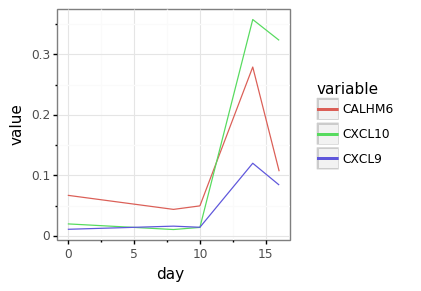

<ggplot: (8726355626221)>
6 ['RNASE6', 'LY86']


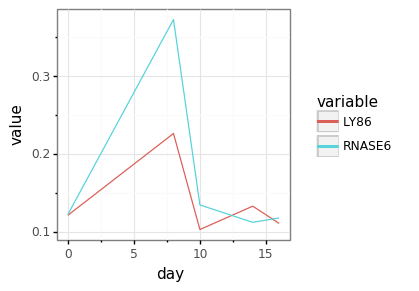

<ggplot: (8726355586369)>


In [269]:
for idx,x in enumerate(cluster_lists):
    print(idx, x)
    plot_df = (df
               .loc[:,cluster_lists[idx]+['day']]
               .reset_index()
               .groupby('day')
               .mean()
               .reset_index()
              )
    plot_df = pd.melt(plot_df, id_vars = 'day')

    plotnine.options.figure_size = (3,3)
    plot = (ggplot(plot_df)
            + theme_bw()
            + geom_line(aes('day','value',color='variable'))
           )
    print(plot)        

In [273]:
_,df = prepare_dataframe(adata,
                         adata.var_names,
                         'TACollectionDay'
                        )
# df = df.rank(pct=True, axis=1)
df['n_genes'] = adata.obs['n_genes'].tolist()
df['n_genes_by_counts'] = adata.obs['n_genes_by_counts'].tolist()
hivar_genes = pd.DataFrame(adata.var.highly_variable).query('highly_variable == True').index.tolist()
df = df.loc[:, hivar_genes+['n_genes','n_genes_by_counts']]
df['day']=[int(x[3:]) for x in df.index]

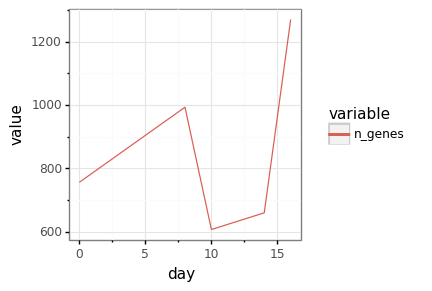

<ggplot: (8726618610649)>


In [275]:
plot_df = (df
           .loc[:,['n_genes','day']]
           .reset_index()
           .groupby('day')
           .mean()
           .reset_index()
          )
plot_df = pd.melt(plot_df, id_vars = 'day')

plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_df)
        + theme_bw()
        + geom_line(aes('day','value',color='variable'))
       )
print(plot)        

In [344]:
adata.obs

,orig.ident,batch,patientID_415-xxxx,TargetPopulation,TACollectionDay,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,...,pct_counts_in_top_500_genes,percent_ribo,percent_mito,percent_SARS2,n_genes,leiden_0.8,CellType,day,leiden,de_groups
AAACCTGAGATGCGAC-1-0,COMET_1024_CD45_Day0,0,1024,CD45,Day0,563,6.335054,1093.0,6.997596,41.079597,...,94.236048,0.142726,0.010979,0.0,563,2,Mono/Macro,0,2,rest
AAACCTGGTCCAACTA-1-0,COMET_1024_CD45_Day0,0,1024,CD45,Day0,1556,7.350516,5553.0,8.622273,36.700882,...,78.696200,0.171799,0.021070,0.0,1556,2,Mono/Macro,0,2,rest
AAACGGGGTTCAGACT-1-0,COMET_1024_CD45_Day0,0,1024,CD45,Day0,418,6.037871,937.0,6.843750,50.053362,...,100.000000,0.249733,0.037353,0.0,418,0,Mono/Macro,0,2,rest
AAAGATGAGTATCTCG-1-0,COMET_1024_CD45_Day0,0,1024,CD45,Day0,579,6.363028,1728.0,7.455298,54.456019,...,95.428241,0.145833,0.016204,0.0,579,2,Mono/Macro,0,6,rest
AAAGCAAAGGTGCTAG-1-0,COMET_1024_CD45_Day0,0,1024,CD45,Day0,609,6.413459,1617.0,7.388946,53.308596,...,93.259122,0.126160,0.006184,0.0,609,3,Mono/Macro,0,3,rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGACTGGT-1-8,COMET_1024_CD45_Day14,8,1024,CD45,Day14,663,6.498282,1322.0,7.187657,40.695915,...,87.670197,0.093041,0.064297,0.0,663,2,Mono/Macro,14,2,target
TTTGGTTGTCTGATTG-1-8,COMET_1024_CD45_Day14,8,1024,CD45,Day14,857,6.754604,2464.0,7.809947,47.727273,...,85.511364,0.068994,0.011364,0.0,857,2,Mono/Macro,14,4,target
TTTGGTTTCTTGTATC-1-8,COMET_1024_CD45_Day14,8,1024,CD45,Day14,1129,7.029973,5718.0,8.651549,66.456803,...,88.999650,0.042497,0.020637,0.0,1129,4,Mono/Macro,14,0,target
TTTGTCACAAGTTCTG-1-8,COMET_1024_CD45_Day14,8,1024,CD45,Day14,561,6.331502,1969.0,7.585789,63.484002,...,96.901981,0.118334,0.015744,0.0,561,1,Mono/Macro,14,7,target


## create new time-series data

In [328]:
patient_id = 1031
marker = 'CD45'

for day in [0,2,6,7,8]:
    if day == 0:
        adata_long = sc.read_10x_mtx(f'/mnt/ibm_lg/daniel_le/data/covid/comet/raw_10x/COMET_1031_CD45_day{day}/')
        adata_long.obs['day'] = day
        adata_long.obs['patient_id'] = patient_id
        adata_long.obs['marker'] = marker
    else:
        adata_slice = sc.read_10x_mtx(f'/mnt/ibm_lg/daniel_le/data/covid/comet/raw_10x/COMET_1031_CD45_day{day}/')
        adata_slice.obs['day'] = day
        adata_slice.obs['patient_id'] = patient_id
        adata_slice.obs['marker'] = marker
        adata_long = adata_long.concatenate(adata_slice)
    
sc.pp.calculate_qc_metrics(adata_long, inplace=True)
sc.pp.filter_genes(adata_long, min_cells=1)
ribo_genes = adata_long.var_names.str.startswith(('RPS','RPL'))
adata_long.obs['percent_ribo'] = np.sum(adata_long[:, ribo_genes].X, axis=1).A1 / np.sum(adata_long.X, axis=1).A1
mito_genes = adata_long.var_names.str.startswith(('MT-'))
adata_long.obs['percent_mito'] = np.sum(adata_long[:, mito_genes].X, axis=1).A1 / np.sum(adata_long.X, axis=1).A1
sc.pp.normalize_total(adata_long, target_sum=1e4)
sc.pp.log1p(adata_long)
adata_long.raw = adata_long
sc.pp.scale(adata_long, max_value=4)
adata_long.obs['cell_id'] = adata_long.obs.index.values
sc.pp.highly_variable_genes(adata_long, 
                            min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_long.write('/mnt/ibm_lg/daniel_le/data/covid/comet/comet_1031_CD45_long.h5ad')

/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/_core/merge.py:461: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)
... storing 'marker' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


In [331]:
input_adata = adata_long
_,df = prepare_dataframe(input_adata,
                         input_adata.var_names,
                         'batch'
                        )
hivar_genes = (pd.DataFrame(input_adata
                           .var
                           .highly_variable)
               .query('highly_variable == True')
               .index
               .tolist()
              )
df = df.loc[:, hivar_genes]
df['day'] = input_adata.obs['day'].values

# create correlation matrix by day
tstack = np.zeros((len(hivar_genes),len(hivar_genes),len(set(df['day']))))
for idx,day in enumerate(set(df['day'])):
    corr = (df
               .query(f'day == {day}')
               .drop('day', axis=1)
               .corr()**2
              )
    corr = corr.replace(0,0.000001)
    tstack[:,:,idx] =np.array(corr)

# stack and compute harmonic mean
tstack_hmean = np.apply_along_axis(hmean, 2, tstack)
tstack_hmean_triu = np.triu(tstack_hmean, k=1)
tstack_hmean_triu[tstack_hmean_triu == 0] = np.nan
tstack_df = pd.DataFrame(tstack_hmean_triu)
tstack_df.columns = corr.columns
tstack_df['gene'] = corr.columns
tstack_melt = (pd.melt(tstack_df, id_vars='gene')
               .dropna()
               .sort_values('value', ascending = False)
              )

In [337]:
# output top correlated gene pairs
tstack_melt_slice = tstack_melt.head(300)

# create contig networks
cluster_lists = []
pair_list = [(x,y) for x,y in zip(tstack_melt_slice['gene'], tstack_melt_slice['variable'])]
possible_genes = [ele for sublist in pair_list for ele in sublist]
possible_genes = list(set(possible_genes))

# testing
# pair_list = [['a','b'], ['a','c'], ['d','e'],['c','a']]
# possible_genes = [ele for sublist in pair_list for ele in sublist]

for key in possible_genes:
    contig_cluster = [key]
    current_step = contig_cluster
    # step1: look for partners
    if len(current_step) > 0:
        next_step = []
        for x in current_step:
            match_list = [sublist for sublist in pair_list if x in sublist]
            match_list = [ele for sublist in match_list for ele in sublist]
            for y in match_list:
                if y not in contig_cluster:
                    contig_cluster.append(y)
                    next_step.append(y)
                
        current_step = next_step

    cluster_lists.append(frozenset(contig_cluster))

cluster_lists = [list(x) for x in set(cluster_lists)]

0 ['CD1C', 'CD1E']


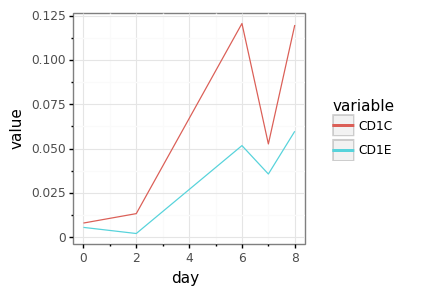

<ggplot: (8726271612781)>
1 ['TREM2', 'A2M']


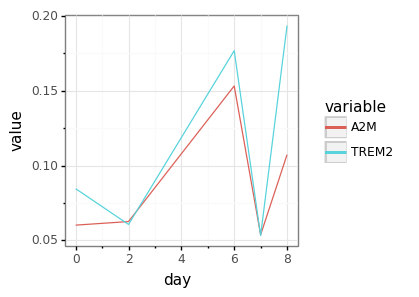

<ggplot: (8726296310053)>
2 ['TMEM176B', 'TMEM176A']


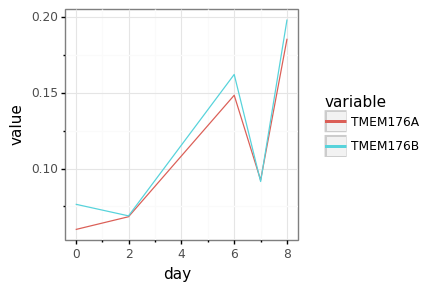

<ggplot: (8726295713921)>
3 ['GZMA', 'IL2RA', 'PRKCQ', 'C12orf75', 'CD69', 'TRBC1', 'MAF', 'CLEC2D', 'CD3D', 'FLT3LG', 'CAMK4', 'CD247', 'SKAP1', 'ITGA4', 'TRAT1', 'SYNE2', 'ETS1', 'PDE3B', 'KLRC1', 'CD96', 'SH2D2A', 'PBXIP1', 'EVL', 'LCK', 'GATA3', 'TNFRSF25', 'CD3E', 'STAT4', 'NCR3', 'IL2RB', 'RNF125', 'IL32', 'TENT5C', 'RASAL3', 'CD3G', 'NKG7', 'ITM2A', 'ITK', 'CD7', 'RORA', 'TMEM173', 'CD2', 'TNFRSF18', 'SEPT1', 'ZAP70', 'SOCS2', 'CBLB', 'SPOCK2', 'NELL2', 'PTPRCAP', 'CD6', 'CD5', 'GIMAP7', 'CD28', 'TRBC2', 'SNRPN', 'GPR171', 'CCR6', 'OCIAD2', 'PTPN22']


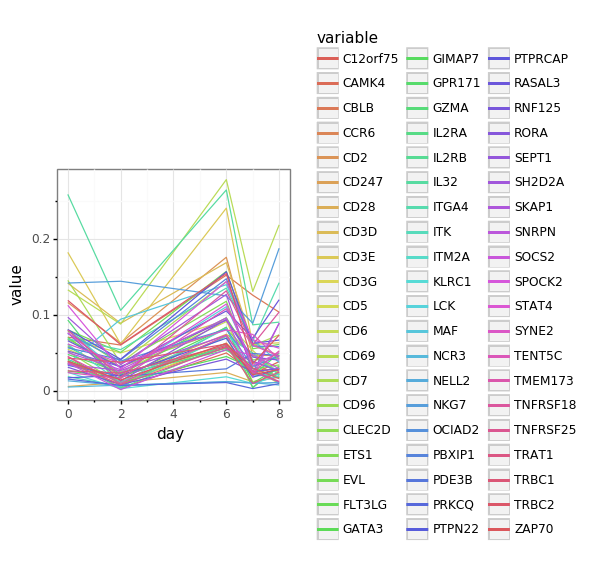

<ggplot: (8726271675485)>


In [338]:
for idx,x in enumerate(cluster_lists):
    print(idx, x)
    plot_df = (df
               .loc[:,cluster_lists[idx]+['day']]
               .groupby('day')
               .mean()
               .reset_index()
              )
    plot_df = pd.melt(plot_df, id_vars = 'day')

    plotnine.options.figure_size = (3,3)
    plot = (ggplot(plot_df)
            + theme_bw()
            + geom_line(aes('day','value',color='variable'))
           )
    print(plot)        

In [335]:
_,df = prepare_dataframe(adata_long,
                         adata_long.var_names,
                         'batch'
                        )
df['n_genes_by_counts'] = adata_long.obs['n_genes_by_counts'].tolist()
df['day'] = adata_long.obs['day'].tolist()

hivar_genes = pd.DataFrame(adata_long.var.highly_variable).query('highly_variable == True').index.tolist()
df = df.loc[:, hivar_genes+['day','n_genes_by_counts']]

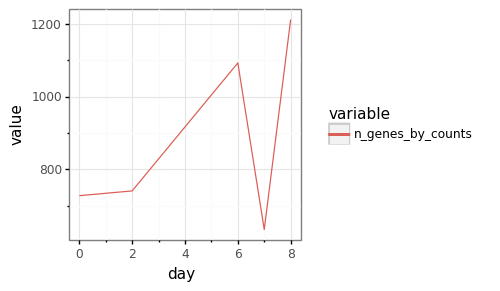

<ggplot: (8726359415109)>


In [336]:
plot_df = (df
           .loc[:,['n_genes_by_counts','day']]
           .reset_index()
           .groupby('day')
           .mean()
           .reset_index()
          )
plot_df = pd.melt(plot_df, id_vars = 'day')

plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_df)
        + theme_bw()
        + geom_line(aes('day','value',color='variable'))
       )
print(plot)        